In [1]:
from google.colab import drive
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
import time
from scipy.signal import fftconvolve
import scipy.stats as stats
import random
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RegularGridInterpolator

drive.mount('/content/drive')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load CIF file
needs coordinates and atomic number to populate grid of electron density

bounding box of Protien [20.1814 20.0748 10.2244] nm, STD: 3.904125680327509 nm


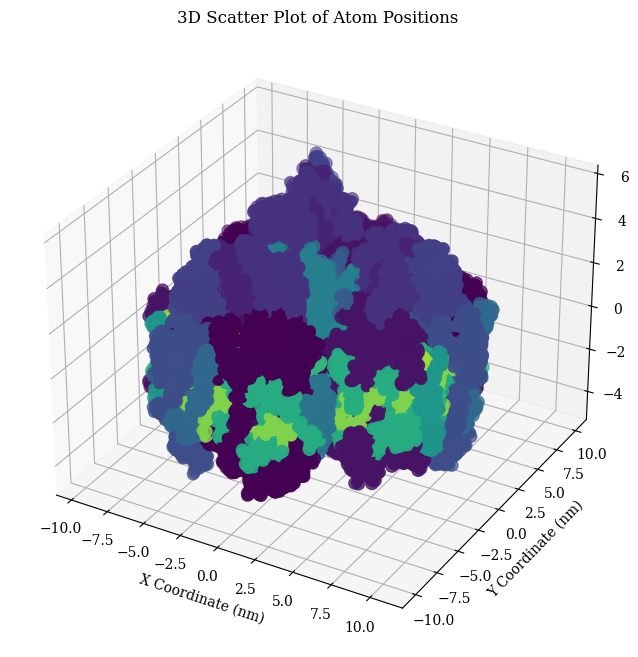

In [2]:
file_path = "drive/MyDrive/Colab Notebooks/"
name = '6pnj.cif'
filename = file_path + name
element_name = []
group_number = []
coordinates = []
# Open the CIF file
with open(filename, 'r') as file:
    # Read lines
    lines = file.readlines()

    # Extract required information from each line
    for line in lines:
        if line.startswith("ATOM") or line.startswith("HETATM"):
            tokens = line.split()
            if "cif" in filename:
                element_name.append(tokens[2])
                group_number.append(tokens[7])
                coordinates.append(np.array(tokens[10:13], dtype=float))
            else:
                element_name.append(tokens[len(tokens) - 1])
                group_number.append(tokens[5])
                coordinates.append(np.array(tokens[6:9], dtype=float)+np.array([80,150,300]))

element_atomic_numbers = {
'h': 1, 'he': 2, 'li': 3, 'be': 4, 'b': 5, 'c': 6, 'n': 7, 'o': 8, 'f': 9, 'ne': 10,
'na': 11, 'mg': 12, 'al': 13,'si': 14, 'p': 15, 's': 16, 'cl': 17, 'ar': 18, 'k': 19,
'ca': 20, 'sc': 21, 'ti': 22, 'v': 23, 'cr': 24, 'mn': 25, 'fe': 26, 'co': 27, 'ni': 28,
'cu': 29, 'zn': 30, 'ga': 31, 'ge': 32, 'as': 33, 'se': 34, 'br': 35, 'kr': 36, 'rb': 37,
'sr': 38, 'y': 39, 'zr': 40, 'nb': 41, 'mo': 42, 'tc': 43, 'ru': 44, 'rh': 45, 'pd': 46,
'ag': 47, 'cd': 48, 'in': 49, 'sn': 50, 'sb': 51, 'te': 52, 'i': 53, 'xe': 54, 'cs': 55,
'ba': 56, 'la': 57, 'ce': 58, 'pr': 59, 'nd': 60, 'pm': 61, 'sm': 62, 'eu': 63, 'gd': 64,
'tb': 65, 'dy': 66, 'ho': 67, 'er': 68, 'tm': 69, 'yb': 70, 'lu': 71, 'hf': 72, 'ta': 73,
'w': 74, 're': 75, 'os': 76, 'ir': 77, 'pt': 78, 'au': 79, 'hg': 80, 'tl': 81, 'pb': 82,
'bi': 83, 'po': 84, 'at': 85, 'rn': 86, 'fr': 87, 'ra': 88, 'ac': 89, 'th': 90, 'pa': 91,
'u': 92, 'np': 93, 'pu': 94, 'am': 95, 'cm': 96, 'bk': 97, 'cf': 98, 'es': 99, 'fm': 100,
'md': 101, 'no': 102, 'lr': 103, 'rf': 104, 'db': 105, 'sg': 106, 'bh': 107, 'hs': 108,
'mt': 109, 'ds': 110, 'rg': 111, 'cn': 112, 'nh': 113, 'fl': 114, 'mc': 115, 'lv': 116,
'ts': 117, 'og': 118}

# Convert element symbols to atomic numbers
atomic_numbers = np.array([element_atomic_numbers[symbol.lower()] for symbol in element_name])
group_number = np.array([int(num) for num in group_number])
coordinates = np.array(coordinates)*1e-10 #convert to metres
coordinates = coordinates - np.mean(coordinates,axis=0) #center the coordinates
print("bounding box of Protien", 1e9*(np.max(coordinates,axis=0)-np.min(coordinates,axis=0)), 'nm, STD:', np.std(1e9*coordinates),'nm')
# Scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(1e9*coordinates[:, 0], 1e9*coordinates[:, 1], 1e9*coordinates[:, 2], c=group_number, s=atomic_numbers * 10, cmap='viridis')
ax.set_xlabel('X Coordinate (nm)')
ax.set_ylabel('Y Coordinate (nm)')
ax.set_zlabel('Z Coordinate (nm)')
ax.set_title('3D Scatter Plot of Atom Positions')
plt.show()



In [3]:
def computeBulkScattering(Thickness, pulse_energy,photon_energy,Zs,dPixel,q):
  # This script calculates photons per pixel given 0.0013 photons per pixel are
  # ascertained from following sheet and beam parameters (LY59 data)
  a = 0.009808379098945963
  b = 698025922.1287639
  c = 0.0012248216063012226
  ppp = a * np.exp(- (q / b) ** 2) + c # 0.000213 # expected photons per pixel
  Thickness0 = 25e-9 # nm sheet thickness
  pulse_energy0 = .24 * 1e-3  # in joules
  photon_energy0 = 7.07 * 1e3 * constants.eV  # 7keV in joules
  Zs0 = 0.57 # detector Distance in m
  dPixel0 = 75e-6 # 75um pixel size

  # scale photons per pixel to new parameters
  ppp*=Thickness/Thickness0
  ppp*=pulse_energy/pulse_energy0
  ppp*=photon_energy0/photon_energy
  ppp*=(Zs0/Zs)**2
  ppp*=(dPixel/dPixel0)**2

  return ppp


## Create electron density map

1.   accumulate electrons into grid to compute electron density map
2.   if protien is in solution, add electron density of water in the surrounding cells
3.   Add negative density of water to ensure there is no average spike on fft
2.  (Optional) Add gassian smoothing to replicate gaussian distribution of scattering factors
2.   compute reciprocal space by computing FFT of density map



water density 38.94830308854864
electronCount 5226879500.0
sum 68666.14166259766


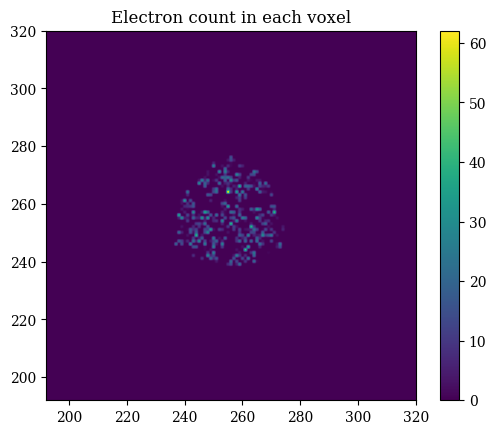

In [11]:
########## Simulation Parameters ##########################################
scale = 250e-9 # size of domain
wavelength = 0.4e-9  # m
N = 512 ############# Electron Density resolution
inSolution = True
##### Constants ###########################################################
water_ed = 3.34563376e29 # water electrons/m**3
###########################################################################

Xbase = np.linspace(-.5, .5, N + 1) * scale
dx = Xbase[1] - Xbase[0]
min_val = min(Xbase)
X1 = 0.5 * (Xbase[:-1] + Xbase[1:])
Y1 = X1; Z1 = X1
water_cell = water_ed*dx**3
print("water density", water_cell)

# Gaussian kernel parameters
sigma = .0259e-9/dx  # Standard deviation of the Gaussian kernel
# Create the Gaussian kernel
kernel_size = int(4 * sigma + 0.5)  # Determine the size of the kernel based on sigma
if kernel_size % 2 == 0:
  kernel_size += 1  # Ensure kernel size is odd
kernel = np.exp(-0.5 * (np.arange(-kernel_size // 2 + 1, kernel_size // 2 + 1) / sigma) ** 2)
kernel = (kernel[None,:,None]*kernel[:, None, None])*kernel
kernel /= np.sum(kernel)  # Normalize the kernel

# Find indices using coordinates
index = np.digitize(coordinates, Xbase) - 1
electronDensity = np.zeros((N,N,N),dtype=np.float32)
electronCount = np.sum(electronDensity)
electronCountRaw = np.sum(electronDensity)
# Assemble electronDensity from atomic position converted to indices
np.add.at(electronDensity, tuple(index.T), atomic_numbers)
if inSolution:
  electronDensity[electronDensity < water_cell] = water_cell
  electronCount = np.sum(electronDensity)
  electronDensity-=water_cell
  #electronDensity/=20
# use custom kernel to smooth as per average atomic scattering factor (optional)
print("electronCount",electronCount)
electronDensity = fftconvolve(electronDensity, kernel, mode='same')
print("sum", np.sum(electronDensity))

plt.imshow(electronDensity[:,:,N//2])
plt.axis([N//2-N//8,N//2+N//8,N//2-N//8,N//2+N//8])
plt.colorbar()
plt.title("Electron count in each voxel")
plt.show()

'''
kx_value = 0
ky_value = 0
kz_value = 1

# Define the wave vector k (kx, ky, kz)
kx, ky, kz = 2 * np.pi / wavelength * np.array([kx_value, ky_value, kz_value])  # Replace with actual values

# Create a grid of coordinates (assuming electronDensity is on a regular grid)
x, y, z = np.meshgrid(X1, Y1, Z1, indexing='ij')

# Compute the phase factor for the incident plane wave
phaseFactor = np.exp(1j * (kx * x + ky * y + kz * z))


x0, y0, z0 = 0, 0, -20e-9  # Assuming point source
x, y, z = np.meshgrid(X1, Y1, Z1, indexing='ij')
r = np.sqrt((x - x0)**2 + (y - y0)**2 + (z - z0)**2)
del x, y, z
phaseFactor = np.exp(1j * 2 * np.pi * r / wavelength) / r
del r
'''
# 3D FFT of electronDensity
structureFactor = np.fft.fftn(electronDensity) # stucture factor
structureFactor = np.fft.fftshift(structureFactor)
farfieldIntensity = np.real(structureFactor * np.conj(structureFactor)) # reciprocal space intensity

## Compute Ewald sphere grid
1. define reciprocal space grid
3. use wavelength to find ewald sphere radius



PhotonCount: 10^ 11.303993284781455
fluence 6.409784256620834e+26 photons/m^2
mass 931.248 kDa
effective concentration 196.8905233023141 mg/mL
Atoms exposed:  168860.60513045138  atoms


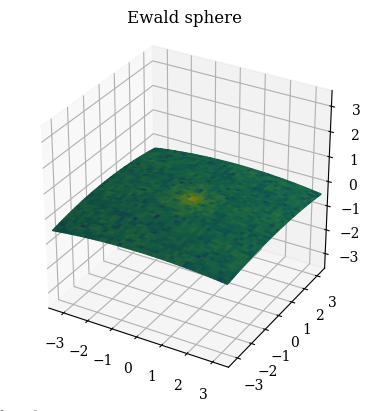

In [14]:
##### More Simulation Parameters ##########################################
Zd = .5  # m
pulseEnergy = .1e-3  # J
focus = 20e-9  # m
sheetThickness = 25e-9  # m
##### Constants ###########################################################
r_e = 2.8179 * 10**-15 # classical electron radii meters
hc = 1.9864e-25;  # m^3 kg/s^2
###########################################################################

photonCount = pulseEnergy/(hc/(wavelength))
print("PhotonCount: 10^", np.log10(photonCount))
J_0 = photonCount/(np.pi/4*(focus)**2)
print("fluence",J_0,"photons/m^2")
masskDa = 0.002*np.sum(atomic_numbers)
print("mass",masskDa,"kDa")
conc = masskDa/(np.pi/4*focus**2*sheetThickness)*1.66054e-24
print("effective concentration",conc,"mg/mL")
numberOfAtomsExposed = 2.15e28*(np.pi/4*focus**2*sheetThickness)
print("Atoms exposed: ",numberOfAtomsExposed," atoms")
# reciprocal space grid
FrequencySampling = 1 / (N * dx)
FGrid = np.arange(N) - N / 2
FX = FGrid * FrequencySampling  # 1/m
FY = FGrid * FrequencySampling  # 1/m
FZ = FGrid * FrequencySampling  # 1/m
# interpolant of reciprocal space
interpolator = RegularGridInterpolator((FX,FY,FZ), farfieldIntensity, bounds_error=False, fill_value=0, method="linear")

# Pixel coordinates
Xs = FX * wavelength * Zd # m
Xs *= 0.07/np.max(Xs)
Ys = FY * wavelength * Zd # m
Ys *= 0.07/np.max(Ys)
Ys, Xs = np.meshgrid(Xs, Ys)
Zs = Xs*0+Zd


# compute pixel position on ewald sphere (q)
# kf = 1/lambda*x_p
# ki = 1/lambda*[0,0,1]
# q = Kf-Ki
Kf = np.stack((Xs,Ys,Zs),axis=-1)
Kf = 1/wavelength*Kf/((Kf[:,:,0]**2+ Kf[:,:,1]**2+Kf[:,:,2]**2)**.5)[:,:,None] # kf = 1/lambda*x_p
Ki = np.zeros((1, 1, 3))  # Initialize a 3D array with shape (1, 1, 3)
Ki[0, 0, 2] = 1/wavelength  # Set the z-component to 1/lambda
q = Kf-Ki

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1.0, 1.0, 1.0])
intensity = farfieldIntensity[:,:,N//2]
surf = ax.plot_surface(q[:,:,0], q[:,:,1], q[:,:,2], facecolors=plt.cm.viridis(np.log1p(intensity)/np.max(np.log1p(intensity))))

ax.set_title('Ewald sphere')
ax.set_xlim(np.min(q), np.max(q))
ax.set_ylim(np.min(q), np.max(q))
ax.set_zlim(np.min(q), np.max(q))

plt.tight_layout()
plt.show()

use pixel coordinates in real space to find pixel coordinates in reciprocal space (recirocal pixel coordinates will be on ewald sphere)

Pixel size:  274.5098039215687 um
(512, 512)
totalPhotonScattered 41410 , Per atom:  0.5790717511991162 or 0.24523185836038647
[-0.219159   0.2183153 -0.219159   0.2183153]
Pixel size:  274.5098039215687 um
(512, 512)
totalPhotonScattered 27954 , Per atom:  0.3909048957503041 or 0.16554482899314762
[-0.219159   0.2183153 -0.219159   0.2183153]
Pixel size:  274.5098039215687 um
(512, 512)
totalPhotonScattered 33402 , Per atom:  0.4670889793178672 or 0.19780812685229723
[-0.219159   0.2183153 -0.219159   0.2183153]
Pixel size:  274.5098039215687 um
(512, 512)
totalPhotonScattered 27669 , Per atom:  0.3869194949028821 or 0.16385704634082426
[-0.219159   0.2183153 -0.219159   0.2183153]
Pixel size:  274.5098039215687 um
(512, 512)
totalPhotonScattered 26160 , Per atom:  0.36581784620547886 or 0.15492068135010165
[-0.219159   0.2183153 -0.219159   0.2183153]
Pixel size:  274.5098039215687 um
(512, 512)
totalPhotonScattered 44279 , Per atom:  0.6191914530631651 or 0.26222220372710825
[-0.219

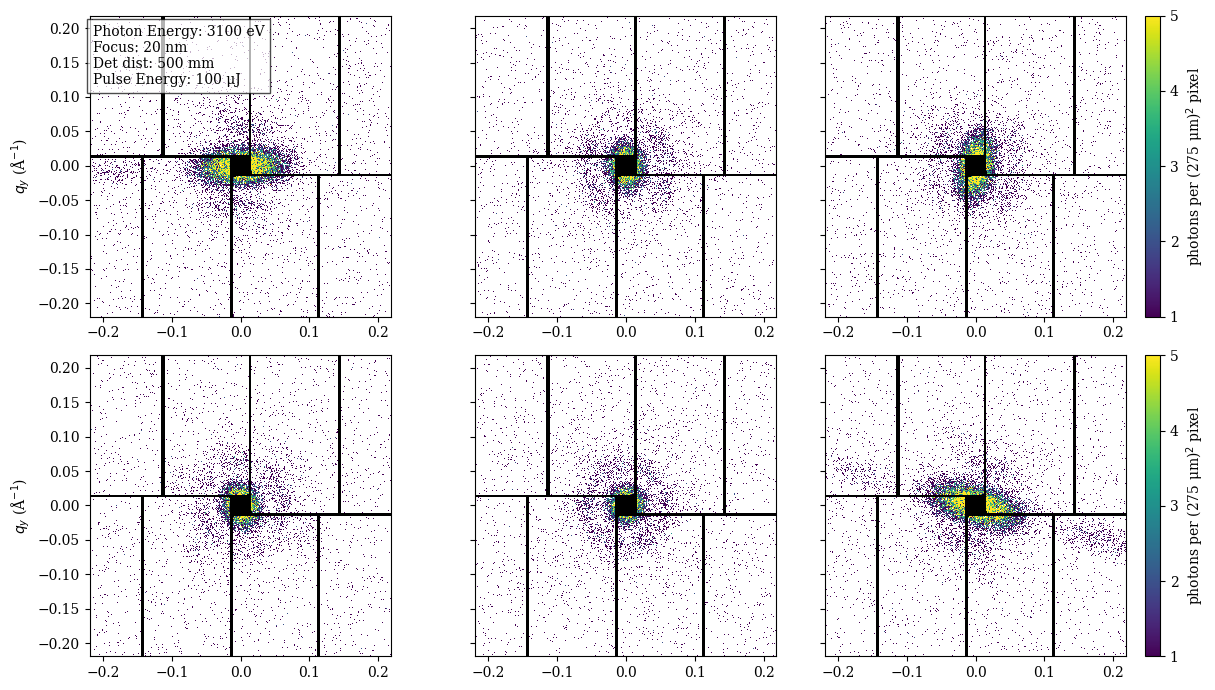

In [15]:
shots = 10
cumulativeIntensity = np.zeros((N,N))

# Plotting
fig = plt.figure(figsize=(12.5, 7))
''''''
for i in range(6):
  rotation_matrix, _ = np.linalg.qr(np.random.rand(3, 3))
  q = np.einsum('ij,klj->kli', rotation_matrix, q) # rotate ewald sphere to random orientation using einstein notation
  intensity = interpolator(q) # interpolate intensity on ewald sphere
  dPixel = Xs[(N//2),N//2]-Xs[(N//2)-1,N//2]
  print('Pixel size: ', dPixel*1e6, 'um')
  qx = 4 * np.pi * np.sin(0.5 * np.arctan(Xs / Zd)) / (wavelength) * 1e-10 # angstrom^-1
  qy = 4 * np.pi * np.sin(0.5 * np.arctan(Ys / Zd)) / (wavelength) * 1e-10 # angstrom^-1

  dOmega = dPixel**2/Zd**2 # pixel solid angle
  frame = J_0*r_e**2*dOmega*intensity
  if inSolution:
    bulkScattering = computeBulkScattering(sheetThickness, pulseEnergy,hc/wavelength,Zd,dPixel,np.sqrt(qx**2+qy**2)*1e10)
    print(intensity.shape)
    frame = frame + bulkScattering
  cumulativeIntensity += frame

  # Adjust pixel intensity with contrast reduction and noise addition for solution scattering
  poisson_values = np.random.poisson(lam =  frame)
  print("totalPhotonScattered",np.sum(poisson_values),", Per atom: ",np.sum(poisson_values)/71511,"or",np.sum(poisson_values)/numberOfAtomsExposed)
  poisson_values = poisson_values.astype(np.double)
  poisson_values[poisson_values==0] = np.nan
  extent = np.array([np.min(qx),np.max(qx),np.min(qy),np.max(qy)])
  ax = fig.add_subplot(2, 3, i+1)
  print(extent)
  im = ax.imshow(poisson_values,extent=extent, cmap='viridis', interpolation='nearest',vmax=5)
  ax.set_xlim([extent[0],extent[1]])
  ax.set_ylim([extent[2],extent[3]])
  if (i+1) in (3, 6):  # Check if subplot is in the first or last column
    cbar = fig.colorbar(im, ax=ax, ticks=np.arange(int(im.get_array().min()), int(im.get_array().max()) + 1))  # Pass the result of imshow to colorbar
    cbar.set_label(f'photons per ({round(dPixel*1e6)} μm)$^2$ pixel')
  if (i+1) in (1, 4):  # Check if subplot is in the first or last column
    ax.set_ylabel(r'$q_y$ (Å$^{-1}$)')
  if (i+1) not in (1, 4):  # Check if subplot is in the first or last column
    ax.set_yticklabels([])  # Remove yticklabels


  stats_text = (f'Photon Energy: {hc/(wavelength)/1.60218e-19:.0f} eV\n'
                f'Focus: {focus*1e9:.0f} nm\n'
                f'Det dist: {Zd*1e3:.0f} mm\n'
                f'Pulse Energy: {pulseEnergy*1e6:.0f} μJ')
  if not i:
    ax.text(0.01, 0.97, stats_text, transform=plt.gca().transAxes,
            fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

  #ax.set_title(f'Single {name} Particle Diffraction in 20 nm sheet')#
  #ax.set_xlabel(r'$q_x$ (Å$^{-1}$)')
  try:
    ax.tripcolor(triangulation, np.zeros(len(vertices)), cmap='gray', shading='flat')
  except:
    pass

  # Add the PolyCollection to the axes
plt.tight_layout()
plt.savefig('SPIsim.svg', format='svg')
plt.show()
cumulativeIntensity/=shots

Text(0.5, 1.0, '2D Triangular Mesh (Triangulation)')

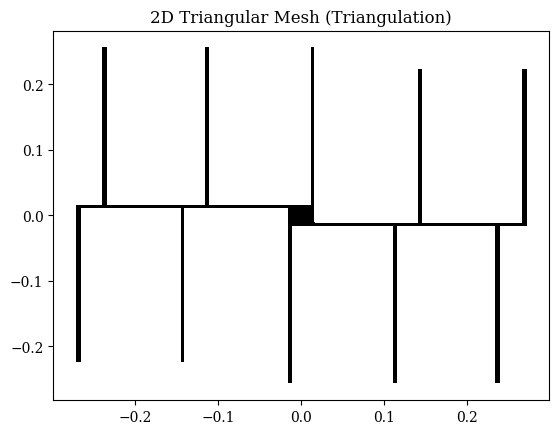

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Function to calculate q
def calculate_q(vertices, Zd, wavelength):
    """
    Calculates the scattering vector q for a set of vertices.

    Args:
        vertices: A NumPy array of shape (N, 2) containing the x and y
                  coordinates of the vertices.
        Zd: Detector distance.
        wavelength: Wavelength of the incident beam.

    Returns:
        A NumPy array of shape (N,) containing the scattering vector q
        for each vertex.
    """
    x, y = vertices[0], vertices[1]  # Extract x and y coordinates
    r = np.sqrt(x**2 + y**2)
    q = (4 * np.pi / wavelength) * (r / (2 * np.sqrt(Zd**2 + r**2)))
    return q * np.array([x, y]) / np.sqrt(x**2 + y**2)

# Parse the ASCII file and calculate vertices
vertices = []
dscale = 3.402 / 3.4902 * 2.54 / 100 *1e-10  # Scaling factor

for line in ascii_data.splitlines():
    if line.strip().startswith("vertex"):
        parts = line.strip().split()
        vertex = np.array([float(parts[1]), float(parts[2])]) * dscale  # Extract x and y and apply scaling
        vertex = calculate_q(vertex, Zd, wavelength)  # Calculate q and adjust vertex
        vertices.append(vertex)

# Convert vertices to a NumPy array
vertices = np.array(vertices)

# Faces or connections (conn is reshaped into a list of triplets, each representing a triangle)
conn = np.arange(len(vertices)).reshape(-1, 3)

# Extract x and y coordinates

# Define the triangulation faces (conn represents the connections)
conn = np.arange(len(vertices)).reshape(-1, 3)

# Create the triangulation object
triangulation = tri.Triangulation( vertices[:, 0],  vertices[:, 1], triangles=conn)


In [ ]:
plt.imshow(bulkScattering, extent=[np.min(qx), np.max(qx), np.min(qy), np.max(qy)])
plt.colorbar()
plt.show()


## SAXS

In [ ]:
Mr = 256
Nr = 5
# Calculate r and theta
r = np.sqrt(qx**2 + qy**2)
theta = np.arctan2(qy, qx)

# Define bins for r and theta
maxr = np.max(r)
rbins = np.linspace(0, maxr, Mr + 1)
tbins = np.linspace(-np.pi, np.pi, Nr + 1)

# Digitize r and theta to find bin indices
rindex = np.digitize(r, rbins[:-1]) - 1
tindex = np.digitize(theta, tbins[:-1]) - 1

count_matrix = np.zeros((Mr, Nr))
photon_matrix = np.zeros((Mr, Nr))

# Use np.add.at to sum the frame values into the corresponding bins
np.add.at(photon_matrix, (rindex, tindex), cumulativeIntensity)
np.add.at(count_matrix, (rindex, tindex), 1)

photon_matrix /= count_matrix
qcenter = 0.5 * (rbins[1:] + rbins[:-1])
photonPer75umPixel2PerProtien = np.nanmean(photon_matrix,axis=1)*(dPixel/75e-6)**-2
plt.figure(figsize=(3, 2)) #Creates a figure 10 inches wide and 6 inches high.
plt.semilogy(qcenter,photonPer75umPixel2PerProtien)
plt.xlim([0,0.5])
plt.ylabel('Intensity')
plt.xlabel(r'$q = \frac{4\pi \sin(\theta)}{\lambda}$')
plt.show()
print("single ppp",np.max(photonPer75umPixel2PerProtien))
numberOfProtiens = 10*(np.pi/4*focus**2*sheetThickness)/65*4.72977e23
print("protien count",numberOfProtiens)
measuredPeak = 5.5e-3;
compareLossInContrast =  measuredPeak/(np.max(photonPer75umPixel2PerProtien)*numberOfProtiens)
print("Exp/Sim",compareLossInContrast)

In [ ]:
# Create the grid
xq = np.linspace(-max(qcenter)/2, max(qcenter)/2, 200)
yq = np.linspace(-max(qcenter)/2, max(qcenter)/2, 200)
xq, yq = np.meshgrid(xq, yq)

# Interpolate
from scipy.interpolate import interp1d
interpolator2 = interp1d(qcenter, photonPer75umPixel2PerProtien, fill_value="extrapolate")
interpolated_values = interpolator2(np.sqrt(xq**2 + yq**2))
frame2 = np.log1p(interpolated_values-1)
N = 200
frame2[N//2-6:N//2+6,N//2-6:N//2+6]=-9
print(frame2.shape)
# Plot
fig = plt.figure(figsize=(10, 10))

plt.imshow(frame2, extent=[-max(qcenter), max(qcenter), -max(qcenter), max(qcenter)])
plt.axis('off')
plt.xlabel('xq')
plt.ylabel('yq')
plt.show()

In [ ]:
'''def reduce_recursively(density, times):
  for _ in range(times):
    N = density.shape[0]
    if N % 2 != 0:
      raise ValueError("Array dimension must be even for reduction.")
    reshaped_density = density.reshape(N//2, 2, N//2, 2, N//2, 2)
    density = reshaped_density.sum(axis=(1,3,5))
    print(density.shape)
  return density

reduced_density = reduce_recursively(electronDensity.copy(), 2)

import plotly.graph_objects as go
import numpy as np

# Assuming 'reduced_density' is your 3D numpy array
N_reduced = reduced_density.shape[0]
X, Y, Z = np.mgrid[0:N_reduced, 0:N_reduced, 0:N_reduced]

fig = go.Figure(data=go.Isosurface(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=reduced_density.flatten(),
    isomin=np.min(reduced_density) + 0.1 * (np.max(reduced_density) - np.min(reduced_density)),
    isomax=np.max(reduced_density),
    surface_count=5, # number of isosurfaces
    opacity=0.6,
    caps=dict(x_show=False, y_show=False)
    ))
fig.show()'''

In [6]:
# File content (assuming this is loaded from a file, but for simplicity, shown as a string here)
ascii_data = """
solid Exported from Blender-2.79 (sub 0)
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 0.199029 -0.199029 0.000000
vertex 0.199029 -0.149272 0.000000
vertex 1.420208 -0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 1.420208 -0.149272 0.000000
vertex 1.420208 -0.199029 0.000000
vertex 0.199029 -0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -0.199029 0.199029 0.000000
vertex -0.199029 0.149272 0.000000
vertex -1.420208 0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -1.420208 0.149272 0.000000
vertex -1.420208 0.199029 0.000000
vertex -0.199029 0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 1.420208 -0.199029 0.000000
vertex 1.420208 -0.149272 0.000000
vertex 1.484690 -0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 1.484690 -0.149272 0.000000
vertex 1.484690 -0.199029 0.000000
vertex 1.420208 -0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -1.420208 0.199029 0.000000
vertex -1.420208 0.149272 0.000000
vertex -1.484690 0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -1.484690 0.149272 0.000000
vertex -1.484690 0.199029 0.000000
vertex -1.420208 0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 1.484690 -0.199029 0.000000
vertex 1.484690 -0.149272 0.000000
vertex 1.810389 -0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 1.810389 -0.149272 0.000000
vertex 1.810389 -0.199029 0.000000
vertex 1.484690 -0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -1.484690 0.199029 0.000000
vertex -1.484690 0.149272 0.000000
vertex -1.810389 0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -1.810389 0.149272 0.000000
vertex -1.810389 0.199029 0.000000
vertex -1.484690 0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 1.810389 -0.199029 0.000000
vertex 1.810389 -0.149272 0.000000
vertex 1.867074 -0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 1.867074 -0.149272 0.000000
vertex 1.867074 -0.199029 0.000000
vertex 1.810389 -0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -1.810389 0.199029 0.000000
vertex -1.810389 0.149272 0.000000
vertex -1.867074 0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -1.867074 0.149272 0.000000
vertex -1.867074 0.199029 0.000000
vertex -1.810389 0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 1.867074 -0.199029 0.000000
vertex 1.867074 -0.149272 0.000000
vertex 3.005470 -0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 3.005470 -0.149272 0.000000
vertex 3.005470 -0.199029 0.000000
vertex 1.867074 -0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -1.867074 0.199029 0.000000
vertex -1.867074 0.149272 0.000000
vertex -3.005470 0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -3.005470 0.149272 0.000000
vertex -3.005470 0.199029 0.000000
vertex -1.867074 0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 3.005470 -0.199029 0.000000
vertex 3.005470 -0.149272 0.000000
vertex 3.082963 -0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 3.082963 -0.149272 0.000000
vertex 3.082963 -0.199029 0.000000
vertex 3.005470 -0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -3.005470 0.199029 0.000000
vertex -3.005470 0.149272 0.000000
vertex -3.082963 0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -3.082963 0.149272 0.000000
vertex -3.082963 0.199029 0.000000
vertex -3.005470 0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 3.082963 -0.199029 0.000000
vertex 3.082963 -0.149272 0.000000
vertex 3.414932 -0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 3.414932 -0.149272 0.000000
vertex 3.414932 -0.199029 0.000000
vertex 3.082963 -0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -3.082963 0.199029 0.000000
vertex -3.082963 0.149272 0.000000
vertex -3.414932 0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -3.414932 0.149272 0.000000
vertex -3.414932 0.199029 0.000000
vertex -3.082963 0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 3.414932 -0.199029 0.000000
vertex 3.414932 -0.149272 0.000000
vertex 3.490824 -0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 3.490824 -0.149272 0.000000
vertex 3.490824 -0.199029 0.000000
vertex 3.414932 -0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -3.414932 0.199029 0.000000
vertex -3.414932 0.149272 0.000000
vertex -3.490824 0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -3.490824 0.149272 0.000000
vertex -3.490824 0.199029 0.000000
vertex -3.414932 0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -0.199029 -0.199029 0.000000
vertex -0.149272 -0.199029 0.000000
vertex -0.149272 -3.297367 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -0.149272 -3.297367 0.000000
vertex -0.199029 -3.297367 0.000000
vertex -0.199029 -0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 0.199029 0.199029 0.000000
vertex 0.149272 0.199029 0.000000
vertex 0.149272 3.297367 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 0.149272 3.297367 0.000000
vertex 0.199029 3.297367 0.000000
vertex 0.199029 0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -3.005470 0.199029 0.000000
vertex -3.082963 0.199029 0.000000
vertex -3.082963 3.297367 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -3.082963 3.297367 0.000000
vertex -3.005470 3.297367 0.000000
vertex -3.005470 0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 3.005470 -0.199029 0.000000
vertex 3.082963 -0.199029 0.000000
vertex 3.082963 -3.297367 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 3.082963 -3.297367 0.000000
vertex 3.005470 -3.297367 0.000000
vertex 3.005470 -0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -1.420208 0.199029 0.000000
vertex -1.484690 0.199029 0.000000
vertex -1.484690 3.297367 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -1.484690 3.297367 0.000000
vertex -1.420208 3.297367 0.000000
vertex -1.420208 0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 1.420208 -0.199029 0.000000
vertex 1.484690 -0.199029 0.000000
vertex 1.484690 -3.297367 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 1.484690 -3.297367 0.000000
vertex 1.420208 -3.297367 0.000000
vertex 1.420208 -0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -3.490824 0.149272 0.000000
vertex -3.414932 0.149272 0.000000
vertex -3.414932 -2.874405 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -3.414932 -2.874405 0.000000
vertex -3.490824 -2.874405 0.000000
vertex -3.490824 0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -1.867074 0.149272 0.000000
vertex -1.810389 0.149272 0.000000
vertex -1.810389 -2.874405 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -1.810389 -2.874405 0.000000
vertex -1.867074 -2.874405 0.000000
vertex -1.867074 0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 3.490824 -0.149272 0.000000
vertex 3.414932 -0.149272 0.000000
vertex 3.414932 2.874405 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 3.414932 2.874405 0.000000
vertex 3.490824 2.874405 0.000000
vertex 3.490824 -0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 1.867074 -0.149272 0.000000
vertex 1.810389 -0.149272 0.000000
vertex 1.810389 2.874405 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 1.810389 2.874405 0.000000
vertex 1.867074 2.874405 0.000000
vertex 1.867074 -0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -0.199029 0.149272 0.000000
vertex -0.199029 0.199029 0.000000
vertex 0.149272 0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 0.149272 0.199029 0.000000
vertex 0.199029 0.199029 0.000000
vertex 0.199029 -0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex 0.199029 -0.149272 0.000000
vertex 0.199029 -0.199029 0.000000
vertex -0.149272 -0.199029 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -0.149272 -0.199029 0.000000
vertex -0.199029 -0.199029 0.000000
vertex -0.199029 0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -0.199029 0.149272 0.000000
vertex 0.149272 0.199029 0.000000
vertex 0.199029 -0.149272 0.000000
endloop
endfacet
facet normal 0.000000 0.000000 -1.000000
outer loop
vertex -0.199029 0.149272 0.000000
vertex 0.199029 -0.149272 0.000000
vertex -0.149272 -0.199029 0.000000
endloop
endfacet
endsolid Exported from Blender-2.79 (sub 0)
"""